In [2]:
!pip install thop ptflops


Loading UMAFall Dataset
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_18_ADL_Sitting_GettingUpOnAChair_2_2016-05-29_20-48-00.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_04_Fall_backwardFall_2_2016-06-13_13-19-53.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_02_Fall_lateralFall_2_2016-06-13_20-50-00.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_03_ADL_Walking_3_2017-04-14_23-45-34.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_19_Fall_lateralFall_3_2016-06-07_21-28-26.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_06_Fall_backwardFall_5_2016-06-13_21-53-34.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_09_ADL_Sitting_GettingUpOnAChair_1_2016-06-04_21-30-12.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_18_ADL_Bending_3_2016-05-29_20-38-11.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_15_ADL_MakingACall_2_2016-12-03_17-23-53.csv
/content/driv

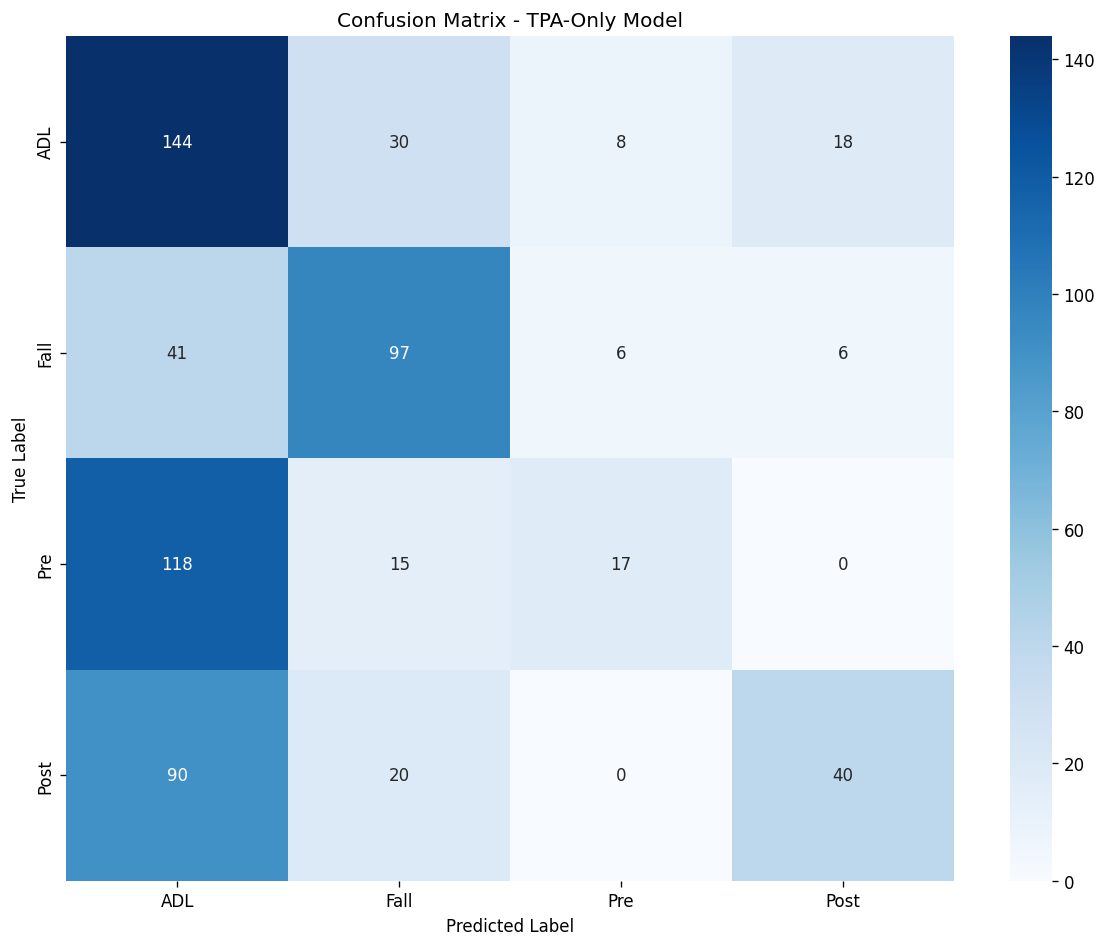

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile
import re


class FallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class UMAFallLoader:
    def __init__(self, data_path, window_size=40, stride=20, sr=20, pre_sec=2.0, post_sec=2.0):
        self.data_path = data_path
        self.window_size = window_size
        self.stride = stride
        self.sr = sr
        self.pre_len = int(sr * pre_sec)
        self.post_len = int(sr * post_sec)

    def parse_filename(self, filename):
        pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
        match = re.match(pattern, filename)

        if match:
            subject_id = int(match.group(1))
            activity_type = match.group(2)
            activity = match.group(3)
            trial = int(match.group(4))
            date = match.group(5)
            return subject_id, activity_type, activity, trial, date
        return None

    def read_all_sensors_file(self, filepath):
        print (filepath)
        sensor_data = {
            'RIGHTPOCKET': {'id': None, 'data': []},
            'CHEST': {'id': None, 'data': []},
            'WRIST': {'id': None, 'data': []},
            'WAIST': {'id': None, 'data': []},
            'ANKLE': {'id': None, 'data': []}
        }

        with open(filepath, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if ';' in line and any(pos in line for pos in sensor_data.keys()):
                    parts = line.strip().split(';')
                    if len(parts) >= 3:
                        sensor_id = parts[1].strip()
                        position = parts[2].strip()
                        if position in sensor_data:
                            sensor_data[position]['id'] = sensor_id

            data_start = False
            for line in lines:
                if '% TimeStamp; Sample No;' in line:
                    data_start = True
                    continue

                if data_start:
                    try:
                        values = [float(v.strip()) for v in line.split(';')]
                        sensor_id = str(int(values[-1]))
                        sensor_type = int(values[-2])
                        data = values[2:5]

                        for position, info in sensor_data.items():
                            if info['id'] == sensor_id:
                                info['data'].append([*data, sensor_type])
                    except:
                        continue

        for position in sensor_data:
            if sensor_data[position]['data']:
                sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
            else:
                sensor_data[position]['data'] = None

        return sensor_data

    def process_sensor_data(self, sensor_data):
        processed_data = {}
        valid_lengths = []

        for position, data in sensor_data.items():
            if data['data'] is not None:
                acc_mask = data['data'][:, -1] == 0
                gyro_mask = data['data'][:, -1] == 1
                mag_mask = data['data'][:, -1] == 2

                acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
                gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
                mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])

                if len(acc_data) > 0:
                    valid_lengths.append(len(acc_data))
                if len(gyro_data) > 0:
                    valid_lengths.append(len(gyro_data))
                if len(mag_data) > 0:
                    valid_lengths.append(len(mag_data))

        if not valid_lengths:
            return None

        min_length = min(valid_lengths)

        for position, data in sensor_data.items():
            if data['data'] is not None:
                acc_mask = data['data'][:, -1] == 0
                gyro_mask = data['data'][:, -1] == 1
                mag_mask = data['data'][:, -1] == 2

                if np.any(acc_mask):
                    acc_data = data['data'][acc_mask][:min_length, :3]
                    acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                    processed_data.update(dict(zip(acc_cols, acc_data.T)))

                if np.any(gyro_mask):
                    gyro_data = data['data'][gyro_mask][:min_length, :3]
                    gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                    processed_data.update(dict(zip(gyro_cols, gyro_data.T)))

                if np.any(mag_mask):
                    mag_data = data['data'][mag_mask][:min_length, :3]
                    mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                    processed_data.update(dict(zip(mag_cols, mag_data.T)))

        if not processed_data:
            return None

        return pd.DataFrame(processed_data)

    def generate_pre_post_labels(self, raw_labels):
        labels = raw_labels.copy()
        n = len(labels)

        for i in range(n):
            if i < n - 1 and labels[i] == 1 and labels[i + 1] != 1:
                end_idx = min(i + 1 + self.post_len, n)
                labels[i+1:end_idx] = 3

        for i in range(n):
            if raw_labels[i] == 1 and (i == 0 or raw_labels[i-1] == 0):
                start_idx = max(0, i - self.pre_len)
                labels[start_idx:i] = 2

        return labels

    def sliding_window(self, data, labels):
        windows = []
        window_labels = []

        for i in range(0, len(data) - self.window_size + 1, self.stride):
            window = data[i:i + self.window_size]
            label_segment = labels[i:i + self.window_size]

            unique, counts = np.unique(label_segment, return_counts=True)
            label_dict = dict(zip(unique, counts))

            threshold = int(self.window_size * 0.1)

            if label_dict.get(1, 0) >= threshold:
                final_label = 1
            elif label_dict.get(3, 0) >= threshold:
                final_label = 3
            elif label_dict.get(2, 0) >= threshold:
                final_label = 2
            else:
                final_label = 0

            windows.append(window)
            window_labels.append(final_label)

        return np.array(windows), np.array(window_labels)

    def prepare_dataset(self, train_samples_per_class=125, test_samples_per_class=50):
        all_files = glob.glob(os.path.join(self.data_path, "*.csv"))

        print("\n" + "="*80)
        print("Loading UMAFall Dataset")
        print("="*80)

        subject_data = {}

        for file in all_files:
            filename = os.path.basename(file)
            info = self.parse_filename(filename)

            if info:
                subject_id = info[0]
                sensor_data = self.read_all_sensors_file(file)
                df = self.process_sensor_data(sensor_data)

                if df is not None:
                    df['activity'] = info[2]

                    if subject_id not in subject_data:
                        subject_data[subject_id] = []
                    subject_data[subject_id].append(df)

        subjects = sorted(subject_data.keys())
        n_subjects = len(subjects)
        n_train = int(n_subjects * 0.8)

        train_subjects = subjects[:n_train]
        test_subjects = subjects[n_train:]

        print(f"Total subjects: {n_subjects}")
        print(f"Train subjects: {train_subjects}")
        print(f"Test subjects: {test_subjects}")

        train_X_list = []
        train_y_list = []
        test_X_list = []
        test_y_list = []

        print("\n" + "="*80)
        print("Processing Training Subjects")
        print("="*80)

        for subject in train_subjects:
            dfs = subject_data[subject]
            subject_df = pd.concat(dfs, ignore_index=True)

            subject_df['activity'] = subject_df['activity'].map(
                lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
            )

            subject_df = subject_df.dropna()

            sensor_columns = [col for col in subject_df.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]

            scaler = StandardScaler()
            subject_df[sensor_columns] = scaler.fit_transform(subject_df[sensor_columns])

            sensor_data = subject_df[sensor_columns].values
            labels = subject_df['activity'].values

            labels = self.generate_pre_post_labels(labels)

            windows, window_labels = self.sliding_window(sensor_data, labels)

            class_counts = np.bincount(window_labels, minlength=4)

            for class_id in range(4):
                class_mask = window_labels == class_id
                class_indices = np.where(class_mask)[0]

                if len(class_indices) > 0:
                    if len(class_indices) >= train_samples_per_class:
                        selected = np.random.choice(class_indices, train_samples_per_class, replace=False)
                    else:
                        selected = np.random.choice(class_indices, train_samples_per_class, replace=True)

                    train_X_list.append(windows[selected])
                    train_y_list.append(window_labels[selected])

            print(f"Subject {subject}: {len(windows)} windows → Class dist: {class_counts}")

        print("\n" + "="*80)
        print("Processing Test Subjects")
        print("="*80)

        for subject in test_subjects:
            dfs = subject_data[subject]
            subject_df = pd.concat(dfs, ignore_index=True)

            subject_df['activity'] = subject_df['activity'].map(
                lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
            )

            subject_df = subject_df.dropna()

            sensor_columns = [col for col in subject_df.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]

            scaler = StandardScaler()
            subject_df[sensor_columns] = scaler.fit_transform(subject_df[sensor_columns])

            sensor_data = subject_df[sensor_columns].values
            labels = subject_df['activity'].values

            labels = self.generate_pre_post_labels(labels)

            windows, window_labels = self.sliding_window(sensor_data, labels)

            class_counts = np.bincount(window_labels, minlength=4)

            for class_id in range(4):
                class_mask = window_labels == class_id
                class_indices = np.where(class_mask)[0]

                if len(class_indices) > 0:
                    if len(class_indices) >= test_samples_per_class:
                        selected = np.random.choice(class_indices, test_samples_per_class, replace=False)
                    else:
                        selected = np.random.choice(class_indices, test_samples_per_class, replace=True)

                    test_X_list.append(windows[selected])
                    test_y_list.append(window_labels[selected])

            print(f"Subject {subject}: {len(windows)} windows → Class dist: {class_counts}")

        train_X = np.concatenate(train_X_list, axis=0)
        train_y = np.concatenate(train_y_list)
        test_X = np.concatenate(test_X_list, axis=0)
        test_y = np.concatenate(test_y_list)

        print("\n" + "="*80)
        print("Final Dataset Statistics")
        print("="*80)
        print(f"Train: {train_X.shape}, Class dist: {np.bincount(train_y, minlength=4)}")
        print(f"Test:  {test_X.shape}, Class dist: {np.bincount(test_y, minlength=4)}")

        return train_X, train_y, test_X, test_y


class FormalTPA(nn.Module):
    def __init__(self, dim, heads=4, tau=1.0, bias_scale=1.0):
        super().__init__()
        assert dim % heads == 0
        self.dim = dim
        self.heads = heads
        self.dim_head = dim // heads
        self.scale = self.dim_head ** -0.5
        self.tau = tau
        self.bias_scale = bias_scale

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        self.delta_norm = nn.LayerNorm(dim)
        self.delta_act = nn.GELU()
        self.delta_net = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim),
            nn.GELU(),
            nn.Linear(dim, heads * 2)
        )
        self.res_norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, T, D = x.shape
        H, Dh = self.heads, self.dim_head

        delta = torch.zeros_like(x)
        delta[:, 1:, :] = x[:, 1:, :] - x[:, :-1, :]
        delta = self.delta_norm(delta)

        gate_scores = self.delta_net(delta)
        logit_bias_scores, value_gate_logits = torch.chunk(gate_scores, 2, dim=-1)

        logit_bias_weights = F.softmax(logit_bias_scores.transpose(1, 2) / self.tau, dim=-1)
        logit_bias = self.bias_scale * logit_bias_weights.unsqueeze(2)

        value_gate = torch.sigmoid(value_gate_logits).permute(0, 2, 1).unsqueeze(-1)

        q = self.q_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        k = self.k_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        v = self.v_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)

        v_gated = v * value_gate

        logits = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        logits = logits + logit_bias
        attn = F.softmax(logits, dim=-1)

        out = torch.matmul(attn, v_gated)
        out = out.permute(0, 2, 1, 3).reshape(B, T, D)
        out = self.out_proj(out)
        out = self.res_norm(x + out)

        return out, logit_bias_weights


class TPAFallModel(nn.Module):
    def __init__(self, in_ch, dim, num_classes, heads, tau, bias_scale, num_layers=2):
        super().__init__()

        self.input_proj = nn.Linear(in_ch, dim)

        self.tpa_layers = nn.ModuleList([
            FormalTPA(dim, heads, tau, bias_scale) for _ in range(num_layers)
        ])

        self.fc = nn.Linear(dim, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.input_proj(x)

        for tpa in self.tpa_layers:
            x, _ = tpa(x)

        x_global = x.mean(dim=1)
        x_global = self.dropout(x_global)

        out = self.fc(x_global)
        return out


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

    return total_loss / total, 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            total_loss += loss.item() * X.size(0)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return total_loss / total, 100. * correct / total, all_preds, all_labels


def main():
    CONFIG = {
        'window_size': 40,
        'stride': 20,
        'batch_size': 512,
        'epochs': 50,
        'hidden_dim': 256,
        'umafall_path': "/content/drive/MyDrive/HAR_Dataset/UMAFALL",
        'tpa_heads': 8,
        'tpa_tau': 1.0,
        'tpa_bias_scale': 1.0,
        'tpa_layers': 3,
        'class_weights': [1.0, 5.0, 8.0, 8.0],
        'sr': 20,
        'pre_sec': 2.0,
        'post_sec': 2.0,
        'train_samples_per_class': 125,
        'test_samples_per_class': 50,
    }

    np.random.seed(42)
    torch.manual_seed(42)

    loader = UMAFallLoader(CONFIG['umafall_path'],
                           window_size=CONFIG['window_size'],
                           stride=CONFIG['stride'],
                           sr=CONFIG['sr'],
                           pre_sec=CONFIG['pre_sec'],
                           post_sec=CONFIG['post_sec'])

    train_X, train_y, test_X, test_y = loader.prepare_dataset(
        train_samples_per_class=CONFIG['train_samples_per_class'],
        test_samples_per_class=CONFIG['test_samples_per_class']
    )

    val_size = int(len(train_X) * 0.2)
    indices = np.random.permutation(len(train_X))
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    val_X = train_X[val_indices]
    val_y = train_y[val_indices]
    train_X = train_X[train_indices]
    train_y = train_y[train_indices]

    train_ds = FallDataset(train_X, train_y)
    val_ds = FallDataset(val_X, val_y)
    test_ds = FallDataset(test_X, test_y)

    train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)

    print("\n" + "="*80)
    print("Build Model (TPA-Only)")
    print("="*80)

    in_channels = train_X.shape[2]
    print(f"Input channels: {in_channels}")
    print(f"Window size: {CONFIG['window_size']}")

    model = TPAFallModel(
        in_ch=in_channels,
        dim=CONFIG['hidden_dim'],
        num_classes=4,
        heads=CONFIG['tpa_heads'],
        tau=CONFIG['tpa_tau'],
        bias_scale=CONFIG['tpa_bias_scale'],
        num_layers=CONFIG['tpa_layers']
    )
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f" ✓ Parameters: {n_params:,}")
    print(f" ✓ TPA: {CONFIG['tpa_layers']} layers, heads={CONFIG['tpa_heads']}, dim={CONFIG['hidden_dim']}")

    weights = torch.FloatTensor(CONFIG['class_weights'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    weights = weights.to(device)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    print("\n" + "="*80)
    print("Class Weights:")
    print("="*80)
    for name, w in zip(['ADL','Fall','Pre','Post'], CONFIG['class_weights']):
        print(f" {name:7s}: {w:.2f}")

    print("\n" + "="*80)
    print("Training Start")
    print("="*80)

    best_val_acc = 0
    best_epoch = 0

    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')

    print("\n" + "="*80)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_epoch}")
    print("="*80)

    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc, preds, gts = evaluate(model, test_loader, criterion, device)

    print("\n" + "="*80)
    print("Test Set Performance")
    print("="*80)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")

    print("\n" + classification_report(gts, preds, labels=[0,1,2,3],
                                target_names=['ADL','Fall','Pre-fall','Post-fall'],
                                digits=4, zero_division=0))

    cm = confusion_matrix(gts, preds, labels=[0,1,2,3])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['ADL','Fall','Pre','Post'],
                yticklabels=['ADL','Fall','Pre','Post'])
    plt.title('Confusion Matrix - TPA-Only Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\nConfusion matrix saved to 'confusion_matrix.png'")

    dummy_input = torch.randn(1, CONFIG['window_size'], in_channels).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"\nModel Statistics:")
    print(f"  Params (M):  {params / 1e6:.2f}")
    print(f"  FLOPs (M):   {flops / 1e6:.2f}")

    import time
    model.eval()
    times = []
    with torch.no_grad():
        for _ in range(100):
            start = time.time()
            _ = model(dummy_input)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            times.append((time.time() - start) * 1000)
    print(f"  Inference (ms): {np.mean(times[10:]):.2f}")


if __name__ == '__main__':
    main()